# Lab no 3 : Pandas, sklearn and hyperparameter tuning

Christophe Thomassin and Cedomir Ljubic

In [1]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np
import matplotlib.pyplot as plt

import time
import joblib
from scipy import stats

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.utils.validation import check_X_y
from sklearn.utils.validation import check_array
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils import check_random_state
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

from utils import rand_checkers

## Q1
In the first part, we consider a dataset where the goal is to predict the number of passengers on a
given flight
What kind of problem is it ? Regression of classification ? Supervised or unsupervised ?

> ### **Answer** : 
> Our model will learn a mapping between features X (features of a given flight) and labels Y (passengers on that flight) on the basis of given data. Therefore the model is **supervised**. Our model makes a numerical prediction and not a class prediction, therefore it is **regression**.


## Q2
Load the training data from Moodle (train.csv.bz2 ; bz2 is a compression format, pandas can
decompress it itself). The target variable is called log_PAX. Do a quick inspection of the dataset.
What are the types of the columns ?

In [2]:
flights = pd.read_csv("train.csv.bz2")
flights.tail(5)

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd
8897,2011-10-02,DTW,ATL,9.263158,10.427055,7.316967
8898,2012-09-25,DFW,ORD,12.772727,12.201552,10.641034
8899,2012-01-19,SFO,LAS,11.047619,10.508746,7.908705
8900,2013-02-03,ORD,PHL,6.076923,10.174042,4.030334
8901,2011-11-26,DTW,ATL,9.526316,9.202674,6.167733


In [3]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DateOfDeparture   8902 non-null   object 
 1   Departure         8902 non-null   object 
 2   Arrival           8902 non-null   object 
 3   WeeksToDeparture  8902 non-null   float64
 4   log_PAX           8902 non-null   float64
 5   std_wtd           8902 non-null   float64
dtypes: float64(3), object(3)
memory usage: 417.4+ KB


In [4]:
flights.isna().sum()

DateOfDeparture     0
Departure           0
Arrival             0
WeeksToDeparture    0
log_PAX             0
std_wtd             0
dtype: int64

> ### **Answer** :
> We have  
>- Three **numerical** feature columns that are saved as float64 data types.
>- Two **categorical** feature columns (deparature, arrival) saved as "object" data types. Because they have no ordering we can even say they are **nominal** feature columns (as opposed to ordinal).
>- One **date** feature column that is saved as an object data type instead of as datetime. Whether or not dates belong to the group of numerical/quantitative data is a question of semantics. We will transform it into several separate numerical columns in the next question however. 

## Q3
Convert dates to proper dates. Create new integers columns containing respectively the day, the
week, the month, the year, a binary variable indicating if this is a work day or holiday (in the US
calendar).

In [5]:
flights["DateOfDeparture"] = pd.to_datetime(
    flights["DateOfDeparture"], format="%Y/%m/%d"
)  # transform DateOfDeparture in datetime

In [6]:
flights['DayOfDeparture'] = flights["DateOfDeparture"].dt.day
flights['WeekOfDeparture'] = flights["DateOfDeparture"].dt.isocalendar().week
flights['MonthOfDeparture'] = flights["DateOfDeparture"].dt.month
flights['YearOfDeparture'] = flights["DateOfDeparture"].dt.year

In [7]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DateOfDeparture   8902 non-null   datetime64[ns]
 1   Departure         8902 non-null   object        
 2   Arrival           8902 non-null   object        
 3   WeeksToDeparture  8902 non-null   float64       
 4   log_PAX           8902 non-null   float64       
 5   std_wtd           8902 non-null   float64       
 6   DayOfDeparture    8902 non-null   int64         
 7   WeekOfDeparture   8902 non-null   UInt32        
 8   MonthOfDeparture  8902 non-null   int64         
 9   YearOfDeparture   8902 non-null   int64         
dtypes: UInt32(1), datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 669.5+ KB


The first four new interger columns have been correctly added. Let's add the holiday column now:

In [8]:
cal = USFederalHolidayCalendar()  # import US holiday calendar
holidays = cal.holidays(
    start=flights["DateOfDeparture"].min(),
    end=flights["DateOfDeparture"].max()
).to_pydatetime()  # extract holiday periods as datetime
flights["Holiday"] = flights["DateOfDeparture"].isin(holidays).astype(bool)
# add binary column Holiday and set 1 if date is in US holidays
flights.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd,DayOfDeparture,WeekOfDeparture,MonthOfDeparture,YearOfDeparture,Holiday
0,2012-06-19,ORD,DFW,12.875000,12.331296,9.812647,19,25,6,2012,False
1,2012-09-10,LAS,DEN,14.285714,10.775182,9.466734,10,37,9,2012,False
2,2012-10-05,DEN,LAX,10.863636,11.083177,9.035883,5,40,10,2012,False
3,2011-10-09,ATL,ORD,11.480000,11.169268,7.990202,9,40,10,2011,False
4,2012-02-21,DEN,SFO,11.450000,11.269364,9.517159,21,8,2,2012,False


We have transformed our 'DateOfDeparture' colummn and we won't be needing it later on so we can drop it here.

In [9]:
flights = flights.drop(columns="DateOfDeparture")


## Q4
First, select numerical features in an automated fashion (not by hand). You can for example use a
list comprehension, or flights.select_dtypes.

In [10]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Departure         8902 non-null   object 
 1   Arrival           8902 non-null   object 
 2   WeeksToDeparture  8902 non-null   float64
 3   log_PAX           8902 non-null   float64
 4   std_wtd           8902 non-null   float64
 5   DayOfDeparture    8902 non-null   int64  
 6   WeekOfDeparture   8902 non-null   UInt32 
 7   MonthOfDeparture  8902 non-null   int64  
 8   YearOfDeparture   8902 non-null   int64  
 9   Holiday           8902 non-null   bool   
dtypes: UInt32(1), bool(1), float64(3), int64(3), object(2)
memory usage: 608.7+ KB


We can see that the columns 2, 3, 4, 5, 6, 7 and 8 have a numerical data type

In [11]:
flights_numerical = flights.select_dtypes(
    include=['float64', 'int32', 'int64', 'UInt32'])
flights_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   WeeksToDeparture  8902 non-null   float64
 1   log_PAX           8902 non-null   float64
 2   std_wtd           8902 non-null   float64
 3   DayOfDeparture    8902 non-null   int64  
 4   WeekOfDeparture   8902 non-null   UInt32 
 5   MonthOfDeparture  8902 non-null   int64  
 6   YearOfDeparture   8902 non-null   int64  
dtypes: UInt32(1), float64(3), int64(3)
memory usage: 460.9 KB


We can verify that out dataframe flights_numerical consists of the exact seven numerical columns in the flights dataframe.

## Q5
We will use the Root Mean Squared Error (RMSE) as a figure of merit (performance measure) for
this prediction task. Explain how it is defined and why it is relevant here


> ### Answer: 
> We define the RMSE as: 
>$$ E(y_{pred}(X,w), y) = \sqrt{ \sum\limits_{i = 1}^{N} \frac{(y_{pred}^{(i)}(X,w) - y^{(i)})^2}{N}} $$ 
where:  
>- $y$ is the vector of the true labels and $y^{(i)}$ is the true value of the i-th example.
>- $y_{pred}(X,w)$ is the vector of our model's predictions given the input matrix $X$ and model parameters $w$. 
>- $y_{pred}^{(i)}(X,w)$ is the model's prediction for the i-th input vector $x^{(i)}$.
>- $N$ is the number of input vectors $x$ we consider at a time. It doesn't matter if they are training or test examples.

>The RMSE is relevant here, because: 
>We know that the sum of squares error function $$ E(y_{pred}, y) = \sum\limits_{i = 1}^{N} \frac{1}{2}(y_{pred}^{(i)}(X,w) - y^{(i)})^2$$ has arisen as a consequence of maximizing the likelihood of $y$ under the assumption that $y$ is given by a deterministic function $y_{pred}(x,w)$ with additive gaussian noise $\epsilon$ so that $$ y = y_{pred}(x,w) + \epsilon $$
>We also know that the argument $y_{pred}^{*}(X,w)$ that minimizes the sum of squares error function (2) also minimizes the RMSE (1).
>**Therefore minimizing the RMSE with respect to $y_{pred}$ corresponds to maximizing the likelihood of $y$.** That's one reason why it's a relevant figure of merit.  
The RMSE is also more relevant than other figures of merit because:
>- It takes the mean of the errors, instead of simply the sum of the squared errors, and therefore is useful when comparing the performance on data sets of different sizes.
>- The benefit of using RMSE over the MSE is that the metric it produces is in terms of the unit being predicted. However the RMSE decreases the amount of penalty put on very "wrong" predictions compared to the MSE.

## Q6
Do a train-test split of the data (a single one, so far. You’ll do K-fold cross validaiton later) and
tune the max_depth parameter of a DecisionTreeRegressor. **Explain briefly how this estimator
does its prediction**. Plot the RMSE on train and test sets as a function of this parameter.

In [12]:
target_name = 'log_PAX'
X = flights_numerical.drop(columns=[target_name])
y = flights_numerical.loc[:, target_name]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)
# Split dataset in a training and a test set (size 20%)

### Answer Q6:
> During training/fitting the Decision Tree Regressor will build a "tree" of nodes and leafs, where each node corresponds to a splitting of the data according a feature caracteristic and each leaf corresponds to a prediction that occurs when there are no more nodes to pass through.  
The leaf values of our model are the averages of the training example predictions associated to that leaf.  
For each node, the training procedure consists in finding the optimal splitting, given a cost function. Given a max depth, which represents the maximum number of nodes a new example will go through before prediction, the model iteratively finds the optimal nodes.
> Prediction for a new input x is made by "running it down" the nodes that were created during the training phase. Once it reaches a leaf, there is already a fixed prediction associated to it.

We want to pick the max depth which gives the lowest generalization error while still having low bias, therefore the following function will highlight the max depth which gives **lowest RMSE on the test data**. Technically, we shouldn't call it test set but rather validation set, because we are tuning our models hyperparameters to it, but for now we keep the notation test data.

In [13]:
def hyperparam_errors_plot(X_train, X_test, y_train, y_test, depth_range=50):
    """
    Computes and plots the train and test error (RMSE) for range of max depths.
    Args:
      X_train (ndarray (n, d)): Training data, m examples, d variables 
      y_train (ndarray (n,)): target values
      X_test (ndarray (m, d)): Test data, m examples, d variables 
      y_test (ndarray (m,)): target values
      depth_range (scalar): Number of max depths to test 
    Returns:
      Plot of the train and test errors
    """
    testerror = np.zeros(depth_range)
    trainerror = np.zeros(depth_range)
    x = np.arange(1, depth_range + 1)

    for i in range(depth_range):
        regressor = DecisionTreeRegressor(random_state=1, max_depth=i+1)
        regressor.fit(X_train, y_train)

        pred_test = regressor.predict(X_test)
        pred_train = regressor.predict(X_train)
        rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
        rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
        testerror[i] = rmse_test
        trainerror[i] = rmse_train

    optimal_maxdepth = np.argmin(testerror) + 1
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.set_title(
        "Find optimal max depth for decision tree regression", fontsize=12)
    ax.set_xlabel("Max depth")
    ax.set_ylabel("Error")

    ax.plot(x, testerror, marker='o',
            color="orangered", label="test error", lw=1)
    ax.plot(x, trainerror, marker='o', color="blue", label="train error", lw=1)
    ax.axvline(optimal_maxdepth, lw=1, color='g')
    ax.annotate("optimal max depth", xy=(optimal_maxdepth, 0.8), xytext=(0.2, 0.4), 
                textcoords='axes fraction', fontsize=10,
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3", 
                                color='r', lw=1))
    ax.xaxis.set_major_locator(plt.MultipleLocator(2))
    ax.legend()

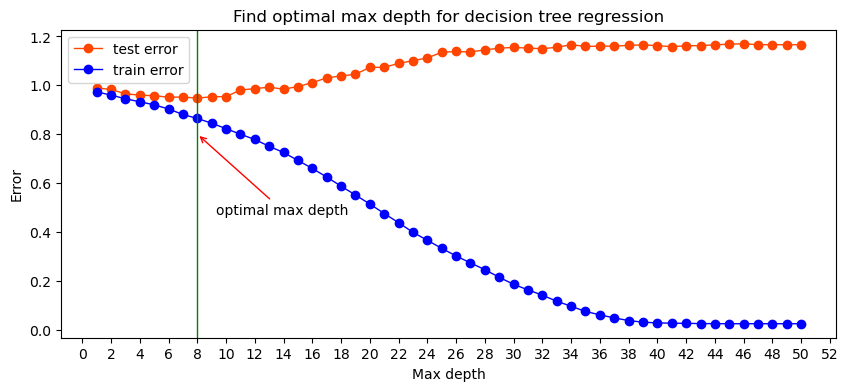

In [14]:
hyperparam_errors_plot(X_train, X_test, y_train, y_test, depth_range=50)

The train error decreases with the max depth and even seems to converge to 0. The test error decreases initially and then increases again. This is a clear sign of overfitting: as the max depth gets larger, the bias reduces and the variance increases. As said before we pick the one that minimizes the test error.

## Q7
Test the impact of using or not a StandardScaler on the features, for this estimator with the found
value of max_depth (use a Pipeline). Explain the results

We test the impact both on the train and set:

In [15]:
scaled_regressor = make_pipeline(
    StandardScaler(), DecisionTreeRegressor(random_state=1, max_depth=8))
regressor = DecisionTreeRegressor(random_state=1, max_depth=8)

# Fitting the two regressors
regressor.fit(X_train, y_train)
scaled_regressor.fit(X_train, y_train)

# Predicting for test data
test_pred_scaled = scaled_regressor.predict(X_test)
test_pred_normal = regressor.predict(X_test)

# Predicting for train data
train_pred_scaled = scaled_regressor.predict(X_train)
train_pred_normal = regressor.predict(X_train)

# Calculating the RMSE for test predictions
rmse_test_scaled = np.sqrt(mean_squared_error(y_test, test_pred_scaled))
rmse_test_normal = np.sqrt(mean_squared_error(y_test, test_pred_normal))

# Calculating the RMSE for train predictions
rmse_train_scaled = np.sqrt(mean_squared_error(y_train, train_pred_scaled))
rmse_train_normal = np.sqrt(mean_squared_error(y_train, train_pred_normal))

print("The respective errors on the test set are:")
print(f"{rmse_test_scaled = }")
print(f"{rmse_test_normal = }")
print("The respective errors on the train set are:")
print(f"{rmse_train_scaled = }")
print(f"{rmse_train_normal = }")

The respective errors on the test set are:
rmse_test_scaled = 0.9476437400032037
rmse_test_normal = 0.9476437400032037
The respective errors on the train set are:
rmse_train_scaled = 0.8642916513584539
rmse_train_normal = 0.8642916513584538


**Answer Question 7** 
> There is no difference in the RMSE of the scaled and the non scaled model. That is because **no feature scaling is required when working with tree based models**. These models are actually invariant to all monotonic transformations of the features/inputs, such as the log transformation for example or in our case the standard scaling (which is monotonic). The phenomenon seemt intuitively, because decision trees split data into multiple groups and the splits depend only on the relative position of the features. For example without scaling we might split if feature $x_1 > 100$ and with scaling if $x_1 > 1$.

> **Therefore we get the same result with and without scaled data.**

## Q8
For a LinearRegression model with fit_intercept=True, test the impact of using a
StandardScaler. Explain

In [16]:
# LR stands for "Linear Regression" and the S for "scaled"
LR = LinearRegression(fit_intercept=True)
LRS = make_pipeline(StandardScaler(), LinearRegression(fit_intercept=True))

LR.fit(X_train, y_train)
LRS.fit(X_train, y_train)

LR_testpred = LR.predict(X_test)
LRS_testpred = LRS.predict(X_test)

LR_test_rmse = np.sqrt(mean_squared_error(y_test, LR_testpred))
LRS_test_rmse = np.sqrt(mean_squared_error(y_test, LRS_testpred))

print("The respective errors on the test set are:")
print(f"{LR_test_rmse = }")
print(f"{LRS_test_rmse = }")

The respective errors on the test set are:
LR_test_rmse = 0.9885140213757009
LRS_test_rmse = 0.9885140213756995


> ### **Answer Q8:**
> We come across yet another interesting mathematical result which is that the **linear regression with an intercept term is invariant to the standardization of its features**, when adapting a maximum likelihood approach to determine the parameters w (meaning without regularization). Out of practice we wanted to prove this property as well in the lines to follow, sorry for the long read. 

>**Proof** :
Let's prove it by showing first that linear regression is invariant to scaling and then to centering of it's features X, when taking the maximum likelihood approach.  
As a reminder, in the frequentist approach our goal is to minimize ${\|y - Xw\|}$ with respect to $w$, or equivalently ${\|y - Xw - w_0\|}$, where $w_0$ is the intercept term and we don't have an extra incercept column in X.

>  **Scaling**: We know that the result of this minimization problem $y_{pred}^{*} = Xw^{*}$ is the orthogonal projection of the label vector $y$ onto the subspace spanned by the column vectors of $X$. By the definition of a span, scaling the vectors that make up the span doesn't change the subspace that it generates. Therefore our prediction $y_{pred}$ is invariant to the scaling of the columns of X. 

>  **Centering**: If we have an input matrix $X$, with $d$ columns denoted as $X^{[i]}$, a parameter vector $w = (w_1, ..., w_d)^T$, an intercept vector $w_0$ and $d$ "centering" vectors $\lambda_i$ (where each element is equal to the mean of the corresponding $X^{[i]}$ column) then we can write our prediction vector $y_{pred}$  as:
$$ y_{pred} = w_0 + w_1(X^{[1]} - \lambda_1) + ... w_d(X^{[d]} - \lambda_d)$$
which can be rewritten as:
$$ y_{pred} = (w_0 - \sum\limits_{i = 1}^{d} w_i\lambda_i) + w_1X^{[1]} + w_dX^{[d]}$$

> The minimization problem for **centered features X** can we written as: $${\|y - (X - J\lambda)w - w_0 \|}$$, where $J$ is a matrix of only ones, $\lambda$ is a vector where each element $\lambda_i$ represents the mean of the column $X^{[i]}$.
> And thanks to the result above, we see that the minimization problem can be rewritten as: $${\|y - Xw - \beta_0\|}$$

> where the intercept $\beta_0 =  w_0 - \sum\limits_{i = 1}^{d} w_i\lambda_i$

> **Therefore we see that the two regression problems, one with and one without centering of features, are identical apart from the intercept term when taking the MLE approach.** The optimal parameters $w^{*} = (w_1^{*}, ..., w_d^{*})^T$ for both regression problems will even be the same, the only difference will be in the intercept terms of the models, but we even know the relationship between them!  
> As the parameters $(w_1^{*}, ..., w_d^{*})$ for both regression problems are the same, regularized linear rigression will also be invariant to centering of the features, as long as we don't regularize the intercept, but will not be invariant to scaling.

## Q9
Now, we use again the full dataset. We will encode the categorical features with a OneHotEncoder.  
Create a one hot encoder instance, fit it on the data, transform the data and display all categories
inferred by the transformer. Delete the transformed data.

First we select the categorical features:

In [17]:
flights_obj = flights.select_dtypes(include=['object'])
flights_obj.tail()

,Departure,Arrival
8897,DTW,ATL
8898,DFW,ORD
8899,SFO,LAS
8900,ORD,PHL
8901,DTW,ATL


We create the one hot encoder instance and we fit and transform the data:

In [18]:
enc = OneHotEncoder(handle_unknown='error', sparse=True)
categorical_onehot = enc.fit_transform(flights_obj).toarray()
# Use OneHotEncoder to encode categorical features
categorical_onehot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

We display the categories:

In [19]:
display(enc.categories_)

[array(['ATL', 'BOS', 'CLT', 'DEN', 'DFW', 'DTW', 'EWR', 'IAH', 'JFK',
        'LAS', 'LAX', 'LGA', 'MCO', 'MIA', 'MSP', 'ORD', 'PHL', 'PHX',
        'SEA', 'SFO'], dtype=object),
 array(['ATL', 'BOS', 'CLT', 'DEN', 'DFW', 'DTW', 'EWR', 'IAH', 'JFK',
        'LAS', 'LAX', 'LGA', 'MCO', 'MIA', 'MSP', 'ORD', 'PHL', 'PHX',
        'SEA', 'SFO'], dtype=object)]

Now we delete the transformed data:

In [20]:
del categorical_onehot

## Q10
Create a Pipeline standardizing the numerical features, and one-hot encoding categorical features,
followed by the application of a RandomForestRegressor to the transformed data.

There might be a more automated way of determining which column names correspond to which category, but we will go for the lazy way as was done in the tutorial notebook:

In [21]:
scaling_columns = ['WeeksToDeparture', 'std_wtd',
                   'DayOfDeparture', 'WeekOfDeparture',
                   'MonthOfDeparture', 'YearOfDeparture']
one_hot_encoding_columns = ['Departure', 'Arrival']
binary_encoding_columns = ["Holiday"]


In [22]:
preprocessor = ColumnTransformer([
    ('binary-encoder', OrdinalEncoder(), binary_encoding_columns),
    ('one-hot-encoder', OneHotEncoder(handle_unknown='error', sparse=True),
     one_hot_encoding_columns),
    ('standard-scaler', StandardScaler(), scaling_columns)
])  

# Create preprocessor with all Encoders and the StandardScaler
forest_processed = make_pipeline(
    preprocessor,
    RandomForestRegressor(random_state=1)
)  # Make pipeline out of preprocessor and RandomForestRegressor


## Q11
Perform grid-search on the cross-validation error to tune simultaneously the n_estimators and
max_depth of the prediction step of your pipeline. Comment on the execution time.

We redefine our training and test sets:

In [23]:
target_name = 'log_PAX'
X = flights.drop(columns=[target_name])
y = flights.loc[:, target_name]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)
X.head()

,Departure,Arrival,WeeksToDeparture,std_wtd,DayOfDeparture,WeekOfDeparture,MonthOfDeparture,YearOfDeparture,Holiday
0,ORD,DFW,12.875000,9.812647,19,25,6,2012,False
1,LAS,DEN,14.285714,9.466734,10,37,9,2012,False
2,DEN,LAX,10.863636,9.035883,5,40,10,2012,False
3,ATL,ORD,11.480000,7.990202,9,40,10,2011,False
4,DEN,SFO,11.450000,9.517159,21,8,2,2012,False


In [24]:
#print("The hyper-parameters for a preprocessed random forest model are:")
# for param_name in forest_processed.get_params().keys():
#    print(param_name)
# We commented this out because we don't want it to take up too much space


In [25]:
%timeit

param_grid = {'randomforestregressor__n_estimators': (np.arange(1, 102, 20)),
              'randomforestregressor__max_depth': (np.arange(1, 102, 20))}

forest_grid = GridSearchCV(forest_processed,
                           param_grid=param_grid,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=12, cv=5)

start = time.time()
forest_grid.fit(X_train, y_train)
elapsed_time = time.time() - start
print(
    f"The RMSE using a {forest_grid.__class__.__name__} model is "
    f"{- forest_grid.score(X_train, y_train):.2f} on the train set"
    f" and {- forest_grid.score(X_test, y_test):.2f} on the test set."
    f" The optimal hyperparams were found in {elapsed_time:.3f} seconds")

The RMSE using a GridSearchCV model is 0.40 on the train set and 0.74 on the test set. The optimal hyperparams were found in 111.522 seconds


> ### **Answer:**
> Gridsearch CV is computationally very expensive because it requires a number of training
runs that can be exponential in the number of parameters. In our case we have two parameters with each 6 choices, so we train $6^2$ models, without even considering the Kfold cross validation. Kfold cross validation then increases the number of training runs necessary by a factor of K (cv). So in our case that gives $6*6*5 = 180$ training runs in order to find the optimal hyperparameters. By increasing the number of n_jobs we speed up the calculation.

## Q12
> Get the estimator with the best params. Save both the full pipeline and the best model to disk
with joblib. Load them from disk. Why is the ability to dump estimators useful ?

In [26]:
print(f"The best set of parameters is: {forest_grid.best_params_}")

The best set of parameters is: {'randomforestregressor__max_depth': 21, 'randomforestregressor__n_estimators': 101}


In [27]:
joblib.dump(forest_processed, 'forest_processed_joblib')
joblib.dump(forest_grid, 'model_best')

['model_best']

In [28]:
model_best = joblib.load("model_best")
forest_proceddes_joblib = joblib.load("forest_processed_joblib")

> ## Answer:
> As machine learning gets more and more advanced, pipelines are becoming very complex and enhanced. Thus, building and using demand a lot of computation time and power. To prevent costly recomputation of a pipeline during the creation or testing, we can use the "dump" and "load" functionalities of joblib. These functions allow us to respectively save and reload python objects to/from a PC's disk. Therefore, we do not need to rerun a model e.g., finish training our parameters, but can simply load it from a file. Furthermore joblib can load and save objects with numpy arrays faster than Pickle, python's built-in method for saving and loading. This can be especially helpful for algorithms for which we need to store whole dataset or have a lot of parameters.

 ## Q13

What is the cost of fitting a KNN ? and of predicting for one new point ?

> ### **Answer:**
> Let us introduce n as the number of points in the training dataset, d as the number of features and k as the number of neighbours that we consider for allocating a new point to a certain cluster. 
For every new point we calculate the distance from the new point to every other point in the training data, then "sort" the distances in a ascending order and consider the k-nearest points to do a majority-vote. It is not necessary to sort the distances array, there are also less computationally expensive algorithms that determine the indexes of the k smallest elements of the array without sorting. 

>This model has no parameters, only hyperparameters such as k and perhaps the distance function used, thus this training needs no fitting.

>The complexity of the fitting is a constant or O(1) as we just have to save the data.

>**The most optimal algorithm can make a prediction for one new point in O(nd) operations.** That all depends on the sorting algorithm used in the last step.
>- Each distance computation requires a runtime of O(d). 
>- We have to compute the distance from the new point n times, which results into a runtime of O(nd). 
>- For the last step we can find the k-th smallest element of the array in O(n) computations using the algorithm from this source:
https://www.geeksforgeeks.org/kth-smallestlargest-element-unsorted-array-set-3-worst-case-linear-time/
Once we have the k-th smallest element we can select the remaining k-1 elements in O(n) computations. Therefore selecting the k smallest indexes of the array takes O(n) operations. 

>Overall we get a cost of predicting a new point of O(nd + n) = O(nd) if we use the most efficient algorithms for the last step.

 ## Q14

Implement a KNearestNeighbor class with __init__, fit and predict. scipy.stats.mode may
be useful for prediction.


In [29]:
class KNearestNeighbours(BaseEstimator):#, ClassifierMixin):
    """KNearestNeighbor classifier."""
    
    def __init__(self, k):
        """Initialize class."""
        self.k = k
        
    def fit(self, X, y):
        """Fit the KNearestNeighbor classifier from the training dataset.

        Args:
            X (np array of shape (n_samples, n_features)): Training data.
            y (np array of shape (n_samples, 1)): Target values.
        Returns:
            self : KNearestNeighbour
                The fitted KNearestNeighbour classifier.
        Errors:
            ValueError : if sizes of X and y don't match.
        """
        X, y = check_X_y(X, y)
        check_classification_targets(y)
        self.classes_ = np.unique(y)
        self.X_train_ = X
        self.y_train_ = y
        self.n_features_in_ = X.shape[1]
        self.n_train_ = X.shape[0]
        
        return self
    
    def predict(self, X):
        """Predict the class labels for the provided data.

        Args:
            X (np array of shape (n_samples, n_features)): Test samples.
        Returns:
            index_closest (ndarray of shape (n_samples,)): Class labels for
                each sample.
        """
        check_is_fitted(self)
        X = check_array(X)
        distances = np.zeros((X.shape[0], self.n_train_))
        k_nearest_indexes = np.zeros((X.shape[0], self.k))
        k_nearest_labels = np.zeros((X.shape[0], self.k))
        y_pred = np.zeros(X.shape[0])
        
        for i in range(X.shape[0]):
            for j in range(self.n_train_):
                distance = np.linalg.norm(X[i,:] - self.X_train_[j,:])
                distances[i, j] = distance
            k_nearest_indexes[i,:] = np.argsort(distances[i,:])[:self.k]
            k_nearest_labels[i,:] = self.y_train_[k_nearest_indexes[i,:].astype(int)]
            
        y_pred = stats.mode(k_nearest_labels, axis=1, keepdims=False)
        return y_pred[0]
    
    def score(self, X, y):
        """Return the average number of samples corectly classified.

        Args:
            X (np array of shape (n_samples, n_features)): Test or train samples.
            y (np array of shape (n_samples,)): Class for each sample.
        Returns:
            score (_type_): average number of samples corectly classified
        Errors:
            ValueError : if sizes of X and y don't match.
        """
        X, y = check_X_y(X, y)
        accuracy_score = np.mean(y == self.predict(X))
        return accuracy_score

## Q15

Generate data with the function rand_checkers on Moodle. Describe the data

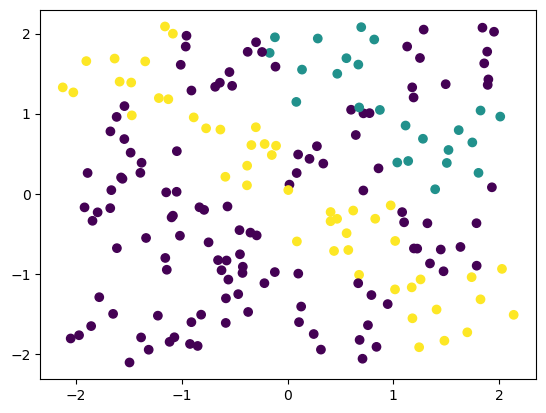

In [30]:
X, y = rand_checkers(201)
plt.scatter(*X.T, c=y)
plt.show(block=False)

> ## **Answer:**
> We can see a dataset with two different features $x_1$ and $x_2$. Each datapoint $x_i$, determined by its values $x_{1,i}$ and $x_{2,i}$, is assigned to one of three categories. The categories have been displayed using three different colours. On first sight, we can not identify any rule that seems to link the category of a data point with its feature-values. Although, we can form hypotheses by examining areas in which one category seems to dominate the number of available data points. For example, for $x_1 \in [-2, 0]$ and $x_2 \in [-2, 0]$ category 1 (red) clearly seems to be the most probable category for new data samples within this area. Thus, we are tempted to a assign a new data point $(x_{1,n+1} = 0, x_{2,n+1} = 0)$ to category 1. Nevertheless, as we can see observing the area $x_1 \in [0, 2]$ and $x_2 \in [-1, 1]$, we can not determine a fast-forward decision rule for all input values of our problem. Therefore, we should look for a reliable framework to categorize new value throughout our entire definition range. 

## Q16

Use 10 fold cross validation to tune the parameter K of your estimator on this dataset (it may
help to have your having your class inherit from BaseEstimator and ClassifierMixin, that can
be imported from sklearn.base). Plot the average loss on the train and test sets as a function of
K. Comment.

**For the loss function we will go with the misclassification rate**, so the percentage of classifications that we got wrong. We will therefore compute the accuracies and then in the final step compute the misclassifications.

In [31]:
plt.style.use('bmh')

In [32]:
def tune_knn(X, y, max_k):
    """Compute and plot the average train and test errors 
    for 10-fold cross validation.
    Args:
        X (np array of shape (n_samples, n_features)): All the data (train and test)
        y (np array of shape (n_samples, 1)): Target values.
    Returns:
        Average accuracies on training
        Average accuracies on test
        Plot of avarage misclassification
    """
    # This array will hold all the avarages
    accu_train_avg = []
    accu_test_avg = []
    for k in range(1, max_k, 1):
        
        strtfdKFold = StratifiedKFold(n_splits=10)
        kfold = strtfdKFold.split(X, y)
        knn = KNearestNeighbours(k=k)
        
        #This array will hold the results for each fold of k-fold CV
        Accuracies_kfold_train = []
        Accuracies_kfold_test = []
        
        for i, (train, test) in enumerate(kfold):
            
            knn.fit(X[train, :], y[train])      
            Accuracies_kfold_train.append(knn.score(X[train, :], y[train]))              
            Accuracies_kfold_test.append(knn.score(X[test, :], y[test]))
                                             
        single_train_avg = round(np.mean(Accuracies_kfold_train), 2)
        single_test_avg  = round(np.mean(Accuracies_kfold_test), 2)
        accu_train_avg.append(single_train_avg)
        accu_test_avg.append(single_test_avg)
        
    x = np.arange(1, max_k, 1)
    fig, ax = plt.subplots(1, 1, figsize=(5, 8))
    plt.style.use('bmh')
    ax.set_title("Misclassification of KNN algo for different params of k", fontsize = 14)
    ax.set_xlabel("k")
    ax.set_ylabel("Misclassification")
    ax.plot(x, 1 - np.array(accu_train_avg), marker='o', label = 'Avg train loss')
    ax.plot(x, 1 - np.array(accu_test_avg), marker='o', label = 'Avg test loss')
    ax.xaxis.set_major_locator(plt.MultipleLocator(2))
    plt.legend()

In [33]:
X, y = rand_checkers(201)

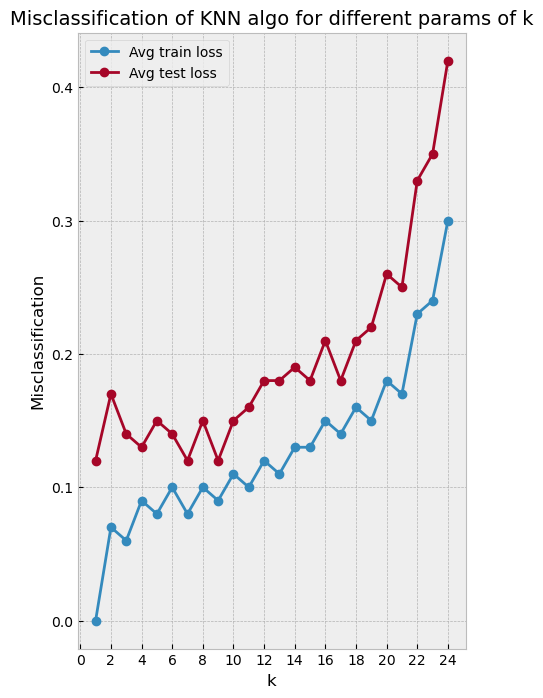

In [34]:
tune_knn(X, y, 25)

## Comment Q16:
The training loss starts at 0, because for 1NN the algo picks the prediction of the train input itself. 
Values of K larger than 10 seem very inefficient and we see that both the train and test loss goes up.  

For values 1 to 10 there is a general upwards trend in the loss function for the train set, but there is no clear pattern for the test set. This may be due to the size of our dataset, that only contains 192 values.

**Optimal values for k seem to be 1, 5 or 7**. 

However if we take more inputs (401 insead of 201) the result for the optimal K changes completely and seems to be **14**.

In [35]:
X, y = rand_checkers(401)

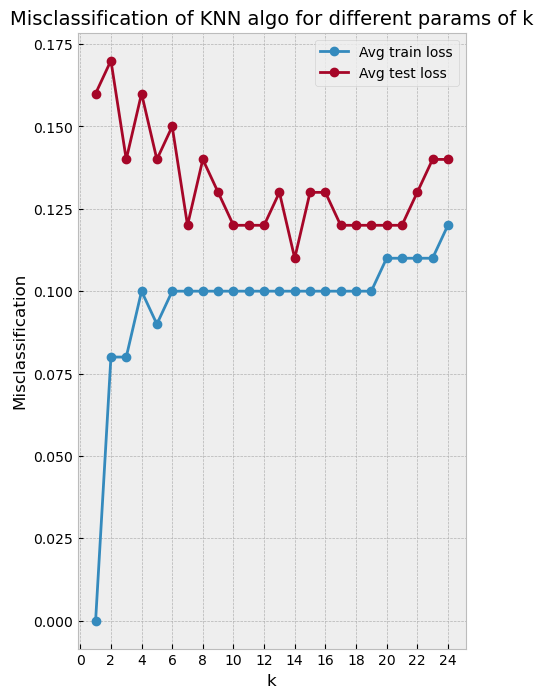

In [36]:
tune_knn(X, y, 25)